<a href="https://colab.research.google.com/github/antonellagambarte/procesamiento_del_lenguaje_I/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag )
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# seleccionamos el tamaño de contexto
max_context_size = 100


# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)


# la longitud de vocabulario de caracteres es:
len(chars_vocab)


# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

Tokenizar

In [5]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

tokenized_text[:1000]

[48,
 27,
 61,
 48,
 51,
 50,
 43,
 19,
 22,
 29,
 50,
 48,
 36,
 11,
 48,
 51,
 27,
 48,
 43,
 55,
 10,
 50,
 48,
 51,
 27,
 48,
 5,
 26,
 17,
 14,
 64,
 48,
 43,
 19,
 48,
 24,
 0,
 50,
 64,
 48,
 27,
 61,
 48,
 52,
 3,
 50,
 21,
 27,
 4,
 50,
 3,
 48,
 61,
 19,
 51,
 27,
 22,
 44,
 3,
 50,
 72,
 45,
 64,
 48,
 27,
 22,
 24,
 3,
 63,
 48,
 16,
 13,
 3,
 60,
 52,
 19,
 51,
 55,
 43,
 27,
 22,
 24,
 27,
 48,
 55,
 48,
 4,
 34,
 48,
 54,
 50,
 29,
 55,
 3,
 64,
 48,
 4,
 19,
 24,
 34,
 55,
 51,
 50,
 48,
 27,
 22,
 48,
 27,
 61,
 48,
 22,
 47,
 43,
 27,
 3,
 50,
 48,
 5,
 76,
 48,
 51,
 27,
 48,
 61,
 55,
 48,
 45,
 71,
 22,
 19,
 29,
 18,
 4,
 24,
 3,
 55,
 4,
 4,
 27,
 64,
 48,
 34,
 22,
 55,
 16,
 13,
 48,
 51,
 27,
 48,
 61,
 55,
 4,
 48,
 72,
 55,
 61,
 61,
 27,
 4,
 48,
 43,
 60,
 4,
 48,
 24,
 3,
 55,
 51,
 19,
 72,
 19,
 50,
 22,
 55,
 61,
 27,
 4,
 48,
 51,
 27,
 61,
 48,
 44,
 55,
 3,
 3,
 19,
 50,
 48,
 55,
 22,
 24,
 19,
 29,
 34,
 50,
 48,
 51,
 27,
 48,
 54,
 55,
 43,
 44,

Organizando y estructurando el dataset

In [6]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))


# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]


tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]


tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]


X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

In [7]:
X.shape

X[0,:10]
y[0,:10]
vocab_size = len(chars_vocab)

Definiendo el modelo

In [10]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=64, input_shape=(None,)))
model.add(SimpleRNN(300, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, None, 64)       │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 300)      │       109,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 78)       │        23,478 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,970 (538.95 KB)

 Trainable params: 137,970 (538.95 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.history_ppl = history_ppl

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

Epoch 1/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 2.2037
 mean perplexity: 4.977196244795195 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 93s 56ms/step - loss: 2.2035
Epoch 2/20
1521/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5924
 mean perplexity: 4.593864920521003 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step - loss: 1.5924
Epoch 3/20
1521/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.5155
 mean perplexity: 4.461670283651684 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 77s 50ms/step - loss: 1.5155
Epoch 4/20
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4845
 mean perplexity: 4.45744876463286 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - loss: 1.4845
Epoch 5/20
1521/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4674
 mean perplexity: 4.4523843629177655 

Saved new model!
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - loss: 1.4674
Epoch 6/20
1521/1522 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.4557
 mean

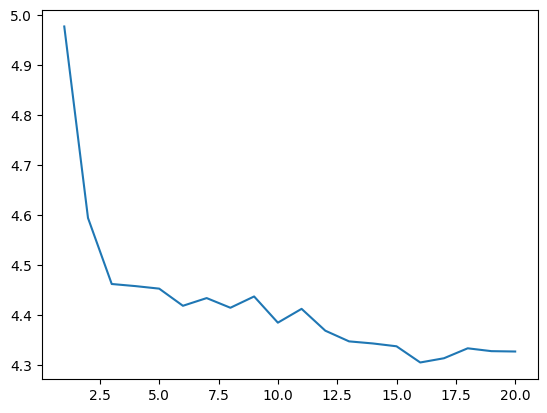

In [12]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)


import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()


# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

In [9]:
model_lstm = Sequential()

model_lstm.add(Embedding(input_dim=vocab_size, output_dim=64, input_shape=(None,)))
model_lstm.add(LSTM(256, return_sequences=True))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_lstm.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 256)      │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 78)       │        20,046 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,742 (1.35 MB)

 Trainable params: 353,742 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6088/6088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0722
 mean perplexity: 5.306665306578103 

Saved new model!
6088/6088 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 2.0721
Epoch 2/20
6081/6088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4136
 mean perplexity: 4.87531050451947 

Saved new model!
6088/6088 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 1.4135
Epoch 3/20
6086/6088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2670
 mean perplexity: 5.082821108072374 

6088/6088 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - loss: 1.2670
Epoch 4/20
6087/6088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1807
 mean perplexity: 5.71111156990246 

6088/6088 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 1.1807
Epoch 5/20
6088/6088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1109
 mean perplexity: 8.515100549379246 

6088/6088 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 1.1108
Epoch 6/20
6083/6088 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0454
 mean perplexity: 21.2658051681076 

6088/6088 ━━━━━━━━━━━━━━━━━━━━ 4

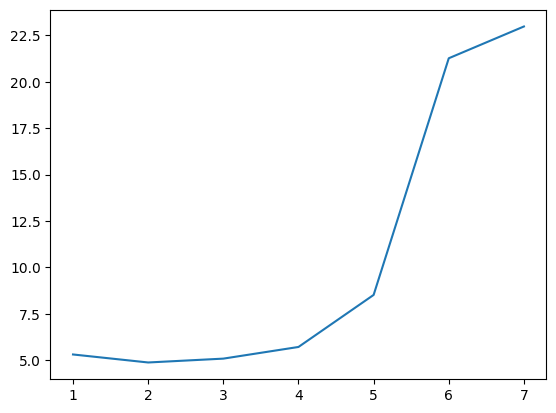

In [10]:
history_ppl_lstm = []

callback_ppl_lstm = PplCallback(val_data=tokenized_sentences_val, history_ppl=history_ppl_lstm)

hist_lstm = model_lstm.fit(X, y, epochs=20, callbacks=[callback_ppl_lstm], batch_size=64)


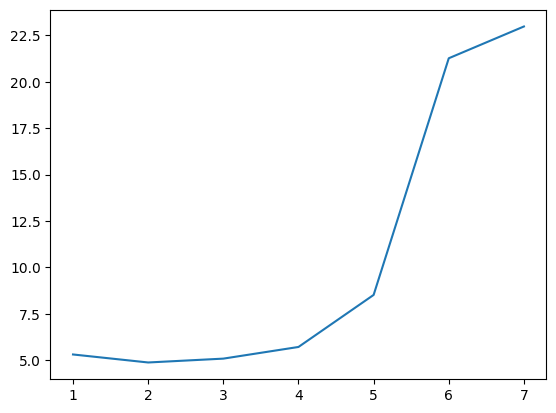

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl_lstm) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_lstm)
plt.show()


# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model_lstm = keras.models.load_model("my_model.keras")

In [14]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [18]:

import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_lstm.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9c6b3080cfa0c55e7d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9c6b3080cfa0c55e7d.gradio.live


Generación de secuencias

In [19]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [20]:

input_text='habia una vez'

generate_seq(model_lstm, input_text, max_length=max_context_size, n_words=30)

'habia una vez en el mar sin despertar a la '

Beam search y muestreo aleatorio

In [21]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [22]:

from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [24]:

# predicción con beam search
salidas = beam_search(model_lstm,num_beams=10,num_words=20,input="habia una vez")

In [25]:

salidas[0]

array([54, 55, 44, 19, 55, 48, 34, 22, 55, 48, 59, 27, 57, 48, 68, 34, 27,
       48, 22, 50,  4, 48, 54, 55, 44,  0, 55, 43, 50,  4, 48, 68, 34])

In [26]:

# veamos las salidas
decode(salidas[0])

'habia una vez que nos habíamos qu'